# 0. Theory

From the Subjective Value formula:
# 
$$
SV_{\text{del}}= \frac{V_{\text{del}}}{1 + k\cdot d}
$$
        Where Vdel is the amount to be gained after a (d) delay, SV the subjective value and k the kappa parameter (discount 
        rate).

From this, we can calculate new values for a given SV. 
$$
V = SV \cdot (1+ K \cdot d)
$$

But, most importantly, we take advantage of the fact that, for this model, the only parameter that impacts SV is the delaye. So:
$$
V_{\text{now}} = SV_{\text{now}} 
$$

With this, we can play arround with $V_{\text{now}}$ and $V_{\text{del}}$ (and $SV_{\text{del}}$) to create different trials that symmetrically sample $\triangle SV$ to increase our confidence model fit. 

$$
\triangle SV = SV_{\text{del}} - SV_{\text{now}}

$$



# 1. Input: ADO

In [689]:

import csv
import os
import random
#participant_code = input ("")
path = '/Volumes/UCDN/datasets/SDM/'
#path = 'Z:/datasets/SDM/'
participant_code = '23_SDM_0004_N'
print('the Participant Code is ' + participant_code)
#MAC path to the File share
participant_split_dir = os.path.join(path,'split') 
participant_trials = os.path.join(participant_split_dir,'{}/cdd/{}_cdd.csv').format(participant_code,participant_code) #This is the psychopy output CSV.We will use it to retrieve the probabilities and image files. 

#Path to the utility model data
utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CDD_analysis.csv')

print('loading fn: {}'.format(participant_trials))
print('loading fn: {}'.format(utility_analysis))

#Extracting the parameters from participants

#Model parameters
kappa_value = None

# Open the CSV file and read its contents into csv_data
def get_kappa_value(utility_analysis):
    with open(utility_analysis, newline='') as file:
        reader = csv.DictReader(file)
    # Iterate through each row in the CSV
        for row in reader:
            if row['subject'] == participant_code:
                kappa_value = float(row['kappa'])
                break  # Exit the loop once the participant is found
    print ('kappa_value',kappa_value)
    return kappa_value

kappa_value = get_kappa_value(utility_analysis)

the Participant Code is 23_SDM_0004_N
loading fn: /Volumes/UCDN/datasets/SDM/split/23_SDM_0004_N/cdd/23_SDM_0004_N_cdd.csv
loading fn: /Volumes/UCDN/datasets/SDM/utility/split_CDD_analysis.csv
kappa_value 0.012000841879144998


# 2. Define the possible options of reward and delay we are going to use.

In [690]:
#Declare the values of immediate values, delayed values, and wait times that we are going to use

# Generate 10 random numbers between 2 and 65
#random_numbers = random.sample(range(2, 65), 19)

# Append 2 to the list of random numbers
amt_immed_options = [2, 5, 10, 15, 18, 20, 27, 30, 34, 35, 41, 43, 44, 47, 51, 62, 63, 64]
#amt_immed_options = [2, 10, 20, 25]
#amt_del_options = random.sample(range(1, 65), 20)
amt_del_options= [5.0,10.0, 20.0, 35.0, 50.0, 65.0]
time_options = [2,7,30,90,180]

V_max= 65.0
V_min = 2.0
print('amt_immed_options',sorted(amt_immed_options))
print('amt_del_options',sorted(amt_del_options))
print('time_options',sorted(time_options))

amt_immed_options [2, 5, 10, 15, 18, 20, 27, 30, 34, 35, 41, 43, 44, 47, 51, 62, 63, 64]
amt_del_options [5.0, 10.0, 20.0, 35.0, 50.0, 65.0]
time_options [2, 7, 30, 90, 180]


# 3. Functions

General useful functions

In [691]:

#To keep the dictionaries in order
def order_keys(dict):
    keys = ['category', 'cdd_immed_amt', 'cdd_delay_amt', 'cdd_delay_wait', 'delay_SV', 'deltaSV']
    return {k: dict[k] for k in keys if k in dict.keys()}

#To unpack nested lsits
def flatten(lst):
    """Flatten a list of lists."""
    return [item for sublist in lst for item in sublist]


def round_to_closest_half(number):
    rounded_number = round(number * 2) / 2
    return 0.5 if rounded_number == 0 else rounded_number

def find_middle(lst):
    if not lst:  # Check if the list is empty
        return "The list is empty."
 
    length = len(lst)  # Get the length of the list
 
    if length % 2 != 0:  # Check if the length is odd
        middle_index = length // 2
        return lst[middle_index]
 
    # If the length is even
    first_middle_index = length // 2 - 1
    second_middle_index = length // 2
    return (lst[first_middle_index], lst[second_middle_index])

In [692]:
#This function adds SV and delta SV to a trials dictionary
def add_SV(trials, kappa_value): 
    """
    This function adds SV and delta SV to a trials dictionary
    """
    trials['delay_SV'] = [(v)/(1+kappa_value*D) for v, D 
                          in zip(trials['cdd_delay_amt'], trials['cdd_delay_wait'])]
    trials['deltaSV'] = [svdel - svimmed for  svdel, svimmed in zip(trials['delay_SV'], trials['cdd_immed_amt'])]
    return trials


def get_SE(kappa_value, amt_del_options, time_options): 
    """
    This function creates the trials of subjective equality.
    Inputs:
        - kappa_value: Kappa value used in the computation.
        - amt_del_options: List of delayed amounts.
        - time_options: List of delay times.
    Output:
        - SE_trials: A dictionary containing immediate options with the same subjective value as delayed options.
    """ 
    SE_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[]}

    for D in time_options:
        cdd_immed_amt_for_D = [round_to_closest_half(v / (1 + kappa_value * D)) for v in amt_del_options]
        
        SE_trials['cdd_immed_amt'].extend(cdd_immed_amt_for_D)
        SE_trials['cdd_delay_amt'].extend(amt_del_options)
        SE_trials['cdd_delay_wait'].extend([D] * len(amt_del_options))
    SE_trials['category'] = ['SE_trials']* len(SE_trials['cdd_immed_amt'])
    
    return SE_trials

def max_neg_delta(kappa_value, amt_immed_options, amt_del_options, time_options):
    """
    Calculates the maximum negative delta subjective value (SV) for all delays that are not catch trials (Vdel > Vn), 
    """
    min_SV_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[],'deltaSV':[]}
    for d in time_options:
        #Initialize local variables
        SV_diff = 0
        ivn = 0  
        ivl = 0  
        for vn in amt_immed_options:
            for vl in amt_del_options:
                if vl <= vn:
                    continue
                iSV_diff = (vl / (1+kappa_value*d)) - vn
                if iSV_diff < SV_diff:
                    SV_diff = iSV_diff
                    ivn,ivl = vn,vl
        min_SV_trials['category'].append('minSV')
        min_SV_trials['cdd_delay_wait'].append(d)
        min_SV_trials['cdd_immed_amt'].append(ivn)
        min_SV_trials['cdd_delay_amt'].append(ivl)
        min_SV_trials['deltaSV'].append(SV_diff)
    return min_SV_trials


In [693]:
#Subjective equality trials
SE_trials = get_SE(kappa_value,amt_del_options, time_options)
SE_trials = add_SV(SE_trials, kappa_value)
SE_trials = order_keys(SE_trials)

#Maximum neg delta without having catch trials
min_SV_trials = max_neg_delta(kappa_value, amt_immed_options, amt_del_options, time_options)
min_SV_trials = add_SV(min_SV_trials, kappa_value)
min_SV_trials = order_keys(min_SV_trials)



Knowing the biggest negative delta, we can calculate the positive

In [694]:
max_sv_diff = [-1.0 * delta_SV for delta_SV in min_SV_trials['deltaSV'] if delta_SV <-1.1]
max_sv_diff


[4.037226355959646, 16.206769914492966, 32.7511383167529, 43.43136611857692]

In [695]:

def get_int_pos_SV_delta(max_sv_diff,amt_immed_options, time_options, Vmax= V_max):

    max_sv_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[]}
    Vimm = min(amt_immed_options)
    for index, delta_sv in enumerate(max_sv_diff, start=1):
        category_value = index
        for D in time_options:
            Vdel = [round_to_closest_half((delta_sv+Vimm)*(1 + kappa_value*D))]
            for v in Vdel:
                if v <= Vmax:
                    max_sv_trials['cdd_delay_amt'].append(v)
                    max_sv_trials['cdd_delay_wait'].append(D)
                    max_sv_trials['cdd_immed_amt'].append(Vimm)
                    max_sv_trials['category'].append('IntPos' + str(category_value))
    return max_sv_trials


Int_pos = get_int_pos_SV_delta(max_sv_diff,amt_immed_options, time_options)
Int_pos = add_SV(Int_pos, kappa_value)
Int_pos = order_keys(Int_pos)


In [696]:
def get_Max_SVdelta(time_options, Vmax=V_max, Vmin=V_min):
    """
    This function creates the trials with the Maximum Positive delta. 
    By assigning the largest amount we can pay to the delayed options and the least we can pay to the immediate options
    """
    Max_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[]}
    Max_SVdelta = {}
    Max_SVdelta['category'] = ['MaxSV']*len(time_options)
    Max_SVdelta['cdd_delay_amt'] = [Vmax]*len(time_options)
    Max_SVdelta['cdd_immed_amt'] = [Vmin]*len(time_options)
    # Set cdd_delay_wait
    Max_SVdelta['cdd_delay_wait'] = time_options
    return Max_SVdelta


Max_SV_trials = get_Max_SVdelta(time_options)
Max_SV_trials = add_SV(Max_SV_trials, kappa_value)
Max_SV_trials = order_keys(Max_SV_trials)
Max_SV_trials

{'category': ['MaxSV', 'MaxSV', 'MaxSV', 'MaxSV', 'MaxSV'],
 'cdd_immed_amt': [2.0, 2.0, 2.0, 2.0, 2.0],
 'cdd_delay_amt': [65.0, 65.0, 65.0, 65.0, 65.0],
 'cdd_delay_wait': [2, 7, 30, 90, 180],
 'delay_SV': [63.47645812596427,
  59.962773644040354,
  47.793230085507034,
  31.248861683247096,
  20.568633881423082],
 'deltaSV': [61.47645812596427,
  57.962773644040354,
  45.793230085507034,
  29.248861683247096,
  18.568633881423082]}

# Visualization

In [697]:
import pandas as pd
def dict_merge(dict1,dict2,dict3,dict4): 
     '''
     Merge dictionaries while keeping values in lists
     '''
     merged_dict = dict1.copy() # Start with the SE dictionary

     # Update values in dict_1 with values from dict_2
     for key, value in  dict2.items():
        merged_dict[key] = merged_dict[key] + value
     for key, value in dict3.items():
        merged_dict[key] = merged_dict[key] + value
     for key, value in dict4.items():
        merged_dict[key] = merged_dict[key] + value
     #for key, value in dict5.items():
      #  merged_dict[key] = merged_dict[key] + value
  
     return merged_dict
trials = dict_merge(SE_trials, min_SV_trials, Int_pos, TotalMAX)
trials['cdd_immed_wait'] = [0]*len(trials['category'])
import pandas as pd
pd.options.display.max_rows = 999
# Convert the dictionary to a DataFrame and set 'category' as index
df_trials = pd.DataFrame(trials)
col_order =['category', 'cdd_immed_amt', 'cdd_immed_wait', 'cdd_delay_amt', 'cdd_delay_wait', 'delay_SV', 'deltaSV']
df_trials = df_trials[col_order]
df_trials['catch_trials'] = df_trials['cdd_immed_amt'] > df_trials['cdd_delay_amt']
#df_trials = df_trials.sort_values(by = ['deltaSV'])
df_trials

,category,cdd_immed_amt,cdd_immed_wait,cdd_delay_amt,cdd_delay_wait,delay_SV,deltaSV,catch_trials
0,SE_trials,5.0,0,5.0,2,4.882804,-0.117196,False
1,SE_trials,10.0,0,10.0,2,9.765609,-0.234391,False
2,SE_trials,19.5,0,20.0,2,19.531218,0.031218,False
3,SE_trials,34.0,0,35.0,2,34.179631,0.179631,False
4,SE_trials,49.0,0,50.0,2,48.828045,-0.171955,False
5,SE_trials,63.5,0,65.0,2,63.476458,-0.023542,False
6,SE_trials,4.5,0,5.0,7,4.612521,0.112521,False
7,SE_trials,9.0,0,10.0,7,9.225042,0.225042,False
8,SE_trials,18.5,0,20.0,7,18.450084,-0.049916,False
9,SE_trials,32.5,0,35.0,7,32.287647,-0.212353,False


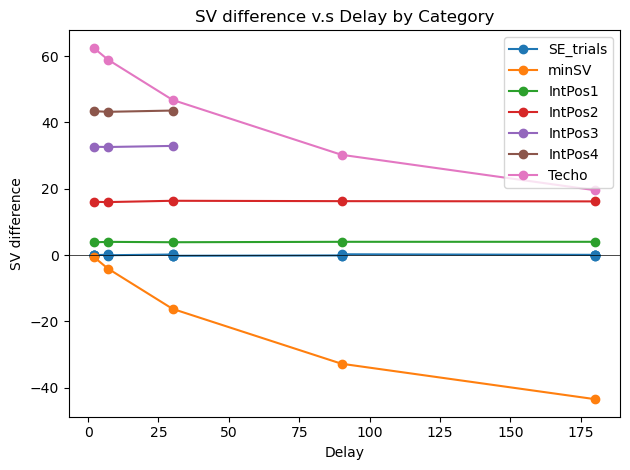

In [698]:
import matplotlib.pyplot as plt

def plot_scatter_by_category(df):
    # Get unique categories and assign a color to each category
    categories = df['category'].unique()
    colors = plt.cm.tab10.colors[:len(categories)]

    # Create a scatter plot for each category with a different color
    for i, category in enumerate(categories):
        category_data = df[df['category'] == category]
        plt.plot(category_data['cdd_delay_wait'], category_data['deltaSV'],'o-', label=category, color=colors[i])

    # Add labels and legend
    plt.xlabel('Delay')
    plt.ylabel('SV difference')
    plt.title('SV difference v.s Delay by Category')
    #plt.axvline(x=70, color='red', linestyle='--', label='xvline=70')
    plt.axhline(y=0, color='black', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot scatter plot with different colors for each category
plot_scatter_by_category(df_trials)

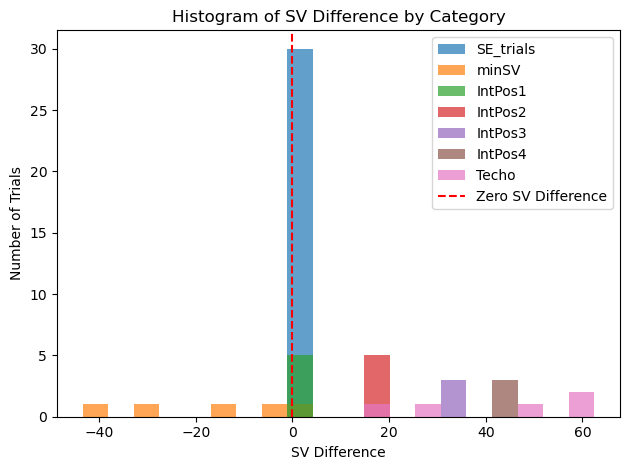

In [699]:
import numpy as np

def plot_histogram_by_category(df):
    # Get unique categories and assign a color to each category
    categories = df['category'].unique()
    colors = plt.cm.tab10.colors[:len(categories)]

    # Determine bin edges
    bin_edges = np.linspace(min(df['deltaSV']), max(df['deltaSV']), 21)  # 20 bins from 0 to maximum deltaSV

    # Create a histogram for SV difference for each category with a different color
    for i, category in enumerate(categories):
        category_data = df[df['category'] == category]
        plt.hist(category_data['deltaSV'], bins=bin_edges, alpha=0.7, label=category, color=colors[i])

    # Add labels and legend
    plt.xlabel('SV Difference')
    plt.ylabel('Number of Trials')
    plt.title('Histogram of SV Difference by Category')
    plt.axvline(x=0, color='red', linestyle='--', label='Zero SV Difference')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot histogram with different colors for each category
plot_histogram_by_category(df_trials)
